# Box21 api

> Interact with your Box21

In [ ]:
#| default_exp box21_api

In [ ]:
#| notest

import os
from dotenv import load_dotenv
load_dotenv()
API_USERNAME = os.environ.get('EMAIL')
API_PASSWORD = os.environ.get('PASSWORD')
API_PROJECT_ID = os.environ.get('PROJECT_ID')

In [ ]:
#| export

import requests

class Box21Api:
    "Box21 Api class"
    def __init__(self, email:str, password:str, host:str, port:int, project_id:int):
        self.email = email
        self.password = password
        self.host = host
        self.port = port
        self.project_id = project_id
        self.token = self.get_token()
        
    def post(self, url, payload, files=None):
        self.token = self.get_token()
        session = requests.Session()
        session.headers.update({'x-access-token': self.token})
        if files:
            response = session.post(self.host + ':' + str(self.port) + url, data=payload, files=files)
        else:
            response = session.post(self.host + ':' + str(self.port) + url, data=payload)
        return response
    
    def get(self, url, payload=None):
        self.token = self.get_token()
        session = requests.Session()
        session.headers.update({'x-access-token': self.token})
        response = session.get(self.host + ':' + str(self.port) + url, data=payload)
        return response
        
    def get_token(self):
        session = requests.Session()

        # Get token
        payload = {
            "email": self.email, "password": self.password}

        response = session.post(self.host + ':' + str(self.port) + '/api/login', data=payload)
        token = response.json().get('token')
        return token

In [ ]:
#| notest

box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)

### Retrieve assets

In [ ]:
#| export

from box21_api.asset import Asset

class Box21Api(Box21Api):
    def get_assets(self, offset:int=0, limit:int=None) -> [Asset]:
        payload = {
            "offset": offset,
            "limit": limit,
            "project_id": self.project_id
        }
        url = '/api/v2/assets'
        response = self.get(url, payload)
        asset_jsons = response.json()

        return [Asset.from_json(asset_json) for asset_json in asset_jsons]
    
    def get_asset(self, asset_id: int) -> Asset:
        url = '/api/asset'
        response = self.post(url, {'asset_id': asset_id})
        asset_json = response.json()    
        return Asset.from_json(asset_json)

In [ ]:
#| notest

box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)
assets = box21_api.get_assets(limit=15)
print('Number of assets retrieved', len(assets))
first_asset = assets[0]
print(first_asset)

Number of assets retrieved 4
Asset({"filename": "eca8f6bc-2090-409e-8e07-7482dba50b34_IMG_0106.JPG", "import": "true", "description": "Human"})


In [ ]:
#| notest

first_asset = box21_api.get_asset(first_asset.id)
print(first_asset)

Asset({"filename": "eca8f6bc-2090-409e-8e07-7482dba50b34_IMG_0106.JPG", "import": "true", "description": "Human"})


In [ ]:
#| export

from PIL import Image
import io

class Box21Api(Box21Api):
    def download_asset(self, asset_id: int) -> Image:
        self.token = self.get_token()
        url = '/api/asset/download'
        payload = {
            "asset_id": asset_id,
            "project_id": self.project_id
        }
        response = self.post(url, payload)

        return Image.open(io.BytesIO(response.content))

In [ ]:
#| notest

box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)
assets = box21_api.get_assets(limit=10)
image = box21_api.download_asset(assets[1].id)

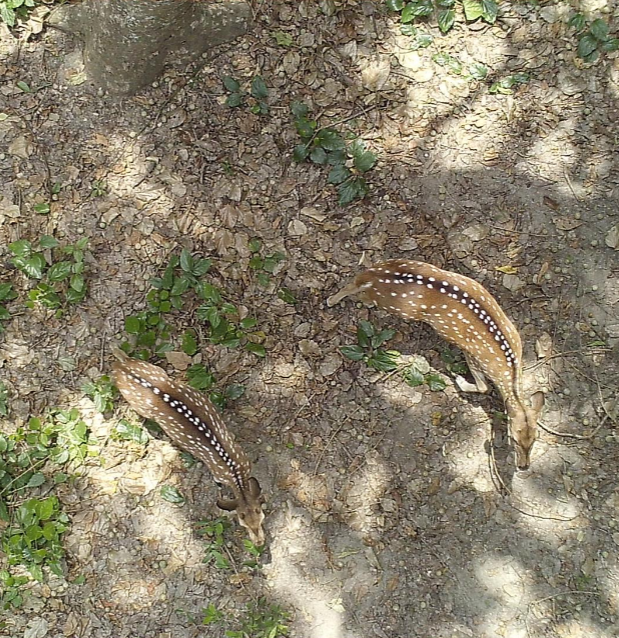

In [ ]:
#| notest

image

### Retrieve annotations

In [ ]:
#| export

from PIL import Image
import io, json
from box21_api.annotation import Annotation, BoundingBox, Keypoint

class Box21Api(Box21Api):
    def get_annotations(self, asset_id: int) -> [Annotation]:
        self.token = self.get_token()
        url = '/api/asset/annotations'
        payload = {
            "asset_id": asset_id,
        }
        response = self.post(url, payload)
        
        annotations = []
        
        for annotation_json in response.json():
            
            asset_id = annotation_json['asset_id']
            annotation_id = annotation_json['id']
            certainty = annotation_json['certainty']
            label_id = annotation_json['label_id']
            label_name = annotation_json['relationships']['label']['name']
            project_id = annotation_json['project_id']
            validated = annotation_json['validated']
            coords = json.loads(annotation_json['coords'])
            
            if annotation_json['type'] == 1:
                x, y, w, h = coords
                annotations.append(
                    BoundingBox(asset_id, annotation_id, certainty, label_id, label_name, project_id, validated, x, y, w, h))
            else:
                x, y = coords
                annotations.append(
                    Keypoint(asset_id, annotation_id, certainty, label_id, label_name, project_id, validated, x, y))
                

        return annotations

In [ ]:
#| notest

box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)
annotations = box21_api.get_annotations(assets[1].id)
print(annotations[1])

BoundingBox(Chital, (0.1641, 0.5291, 0.2766, 0.3381))


### Update asset meta

An asset has meta which is a list of key value pairs. You can add, update and delete them via the api

In [ ]:
#| export

class Box21Api(Box21Api):
    def update_asset_meta(self, asset_id: int, key: str, value: str) -> [Annotation]:
        self.token = self.get_token()
        url = '/api/asset/meta/update-value'
        payload = {
            "asset_id": asset_id,
            "key": key,
            "value": value
        }
        response = self.post(url, payload)
        
        return Asset.from_json(response.json())
    
    def delete_asset_meta_key(self, asset_id: int, key: str) -> [Annotation]:
        self.token = self.get_token()
        url = '/api/asset/meta/delete-key'
        payload = {
            "asset_id": asset_id,
            "key": key
        }
        response = self.post(url, payload)
        
        return Asset.from_json(response.json())

In [ ]:
#| notest

box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)
updated_asset = box21_api.update_asset_meta(assets[0].id, 'some_new_key', 'some new value')

print(json.loads(updated_asset.meta))

{'filename': 'eca8f6bc-2090-409e-8e07-7482dba50b34_IMG_0106.JPG', 'import': 'true', 'description': 'Human', 'some_new_key': 'some new value'}


In [ ]:
#| notest

box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)
updated_asset = box21_api.delete_asset_meta_key(assets[0].id, 'some_new_key')

print(json.loads(updated_asset.meta))

{'filename': 'eca8f6bc-2090-409e-8e07-7482dba50b34_IMG_0106.JPG', 'import': 'true', 'description': 'Human'}


### Get labels

Get all labels for a specific project

In [ ]:
#| export

from box21_api.label import Label

class Box21Api(Box21Api):
    def get_labels(self) -> [Label]:
        self.token = self.get_token()
        url = '/api/labels'
        payload = {
            "project_id": self.project_id
        }
        response = self.post(url, payload)
        
        labels = []
        for label_json in response.json():
            labels.append(
                Label(
                    id=label_json['id'],
                    name=label_json['name'],
                    parent_id=label_json['parent_id'],
                    project_id=label_json['project_id'],
                    type=label_json['type']
                ))
        
        return labels

In [ ]:
#| notest

box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)
labels = box21_api.get_labels()
print(labels[0])

Label(('Bounding box', 'Chital', 1))


Get all annotations for a label:

In [ ]:
class Box21Api(Box21Api):
    def get_label_annotations(self, label: Label) -> [Annotation]:
        self.token = self.get_token()
        url = '/api/label/annotations'
        payload = {
            "label_id": label.id
        }
        response = self.post(url, payload)
        
        annotations = []
        
        for annotation_json in response.json():
            
            asset_id = annotation_json['asset_id']
            annotation_id = annotation_json['id']
            certainty = annotation_json['certainty']
            label_id = annotation_json['label_id']
            label_name = annotation_json['relationships']['label']['name']
            project_id = annotation_json['project_id']
            validated = annotation_json['validated']
            coords = json.loads(annotation_json['coords'])
            
            if annotation_json['type'] == 1:
                x, y, w, h = coords
                annotations.append(
                    BoundingBox(asset_id, annotation_id, certainty, label_id, label_name, project_id, validated, x, y, w, h))
            else:
                x, y = coords
                annotations.append(
                    Keypoint(asset_id, annotation_id, certainty, label_id, label_name, project_id, validated, x, y))
        return annotations

In [ ]:
#| notest

box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)
annotations = box21_api.get_label_annotations(labels[0])
print(len(annotations))
for annotation in annotations:
    print(annotation)

2
BoundingBox(Chital, (0.1641, 0.5291, 0.2766, 0.3381))
BoundingBox(Chital, (0.525, 0.3911, 0.3484, 0.3532))


### Adding and deleting assets

In [ ]:
#| export

from pathlib import Path

class Box21Api(Box21Api):
    def add_asset(self, file_path: Path, meta) -> [Asset]:
        
        if not isinstance(meta, dict):
            return 'meta argument should be a python dictionary'
        
        self.token = self.get_token()
        url = '/api/assets/add'
        payload = {
            'meta': json.dumps(meta),
            'filename': file_path.name
        }
        files = {'file': open(file_path, 'rb')}
        response = self.post(url, payload, files=files)
        print(response.text)
        
        return Asset.from_json(response.json())
    
    def delete_assets(self, asset_ids: [int]):
        url = '/api/assets/delete'
        payload = {
            'asset_ids': json.dumps(asset_ids)
        }
        response = self.post(url, payload)

In [ ]:
#| notest

image.save('example.png')
file_path = Path('example.png')
box21_api = Box21Api(API_USERNAME, API_PASSWORD, 'https://box21.ai', 443, API_PROJECT_ID)
asset = box21_api.add_asset(file_path, {'testing': True})

{"deleted":null,"filename":"b0e5e840-2549-42b8-829f-9ce7f4846866_example.png","id":370,"in_validation_set":false,"liked":false,"meta":"{\"testing\": true}","original_category":"","path":"b0e5e840-2549-42b8-829f-9ce7f4846866_example.png","project_id":1,"unclear":null,"validated":"false"}



In [ ]:
#| notest
print('Number of assets before delete', len(box21_api.get_assets()))
box21_api.delete_assets([asset.id])
print('Number of assets after delete', len(box21_api.get_assets()))

Number of assets before delete 7
true

Number of assets after delete 6
